In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn as sk
import sklearn.model_selection
import albumentations as A
import cv2
import itertools
import os
import time
from pathlib import Path
from tqdm.notebook import tqdm
import math
import pickle
from scipy import ndimage

# pytorch stuff
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.models as models
from torch.utils.data import Dataset, DataLoader

# need for AMP
from torch.cuda.amp import autocast
from torch.cuda.amp import GradScaler

torch.manual_seed(3)

#https://github.com/mcordts/cityscapesScripts

## Data

1. To get the data go to https://www.cityscapes-dataset.com/ and register. Then download these files:
`gtFine_trainvaltest.zip` and `leftImg8bit_trainvaltest.zip`. Put the data in your gpu and unzip.

2. Go to directory `utils` open the file `preprocess_data.py` and replace the following paths
`cityscapes_data_path` and `cityscapes_meta_path`.

3. Run `python preprocess_data.py`

In [2]:
PATH = Path('/data2/yinterian/cityscapes/')

In [3]:
def read_image(path):
    im = cv2.imread(str(path))
    return cv2.cvtColor(im, cv2.COLOR_BGR2RGB)

In [4]:
list((PATH/"leftImg8bit/train/zurich").iterdir())[:10] 

[PosixPath('/data2/yinterian/cityscapes/leftImg8bit/train/zurich/zurich_000051_000019_leftImg8bit.png'),
 PosixPath('/data2/yinterian/cityscapes/leftImg8bit/train/zurich/zurich_000092_000019_leftImg8bit.png'),
 PosixPath('/data2/yinterian/cityscapes/leftImg8bit/train/zurich/zurich_000117_000019_leftImg8bit.png'),
 PosixPath('/data2/yinterian/cityscapes/leftImg8bit/train/zurich/zurich_000003_000019_leftImg8bit.png'),
 PosixPath('/data2/yinterian/cityscapes/leftImg8bit/train/zurich/zurich_000071_000019_leftImg8bit.png'),
 PosixPath('/data2/yinterian/cityscapes/leftImg8bit/train/zurich/zurich_000040_000019_leftImg8bit.png'),
 PosixPath('/data2/yinterian/cityscapes/leftImg8bit/train/zurich/zurich_000121_000019_leftImg8bit.png'),
 PosixPath('/data2/yinterian/cityscapes/leftImg8bit/train/zurich/zurich_000048_000019_leftImg8bit.png'),
 PosixPath('/data2/yinterian/cityscapes/leftImg8bit/train/zurich/zurich_000045_000019_leftImg8bit.png'),
 PosixPath('/data2/yinterian/cityscapes/leftImg8bit/tra

(<matplotlib.image.AxesImage at 0x7f7816c72970>, (1024, 2048, 3))

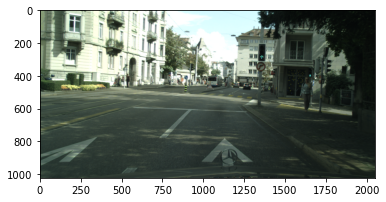

In [5]:
path = PATH/"leftImg8bit/train/zurich/zurich_000051_000019_leftImg8bit.png"
im1 = read_image(path)
plt.imshow(im1), im1.shape

In [6]:
list((PATH/"meta").iterdir())[:10] 

[PosixPath('/data2/yinterian/cityscapes/meta/label_imgs'),
 PosixPath('/data2/yinterian/cityscapes/meta/class_weights.pkl')]

In [7]:
list((PATH/"meta/label_imgs").iterdir())[:10] 

[PosixPath('/data2/yinterian/cityscapes/meta/label_imgs/bremen_000260_000019.png'),
 PosixPath('/data2/yinterian/cityscapes/meta/label_imgs/weimar_000005_000019.png'),
 PosixPath('/data2/yinterian/cityscapes/meta/label_imgs/ulm_000048_000019.png'),
 PosixPath('/data2/yinterian/cityscapes/meta/label_imgs/stuttgart_000139_000019.png'),
 PosixPath('/data2/yinterian/cityscapes/meta/label_imgs/cologne_000012_000019.png'),
 PosixPath('/data2/yinterian/cityscapes/meta/label_imgs/krefeld_000000_022162.png'),
 PosixPath('/data2/yinterian/cityscapes/meta/label_imgs/hanover_000000_030781.png'),
 PosixPath('/data2/yinterian/cityscapes/meta/label_imgs/darmstadt_000027_000019.png'),
 PosixPath('/data2/yinterian/cityscapes/meta/label_imgs/hanover_000000_045841.png'),
 PosixPath('/data2/yinterian/cityscapes/meta/label_imgs/tubingen_000090_000019.png')]

(<matplotlib.image.AxesImage at 0x7f7815361220>, (1024, 2048, 3))

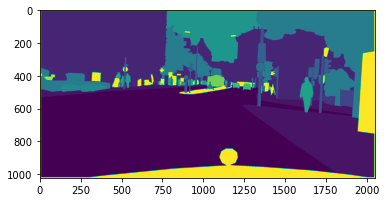

In [8]:
path = PATH/"meta/label_imgs/zurich_000051_000019.png"
label_img = read_image(path)
plt.imshow(label_img[:,:,0]), label_img.shape

In [9]:
(label_img[:,:,0] == label_img[:,:,2]).sum(), 1024*2048

(2097152, 2097152)

In [10]:
# 20 classes
label_img.reshape(-1).min(), label_img.reshape(-1).max()

(0, 19)

## Resizing images
Note that this should be done before training and not `during` training. 

In [11]:
def resize_image(img, img_h=532, img_w=1064):
    img = cv2.resize(img, (img_w, img_h), interpolation=cv2.INTER_NEAREST) # (shape: (512, 1024, 3))
    return img

In [12]:
x = resize_image(im1)
y = resize_image(label_img[:,:,0])

In [13]:
x.shape, y.shape

((532, 1064, 3), (532, 1064))

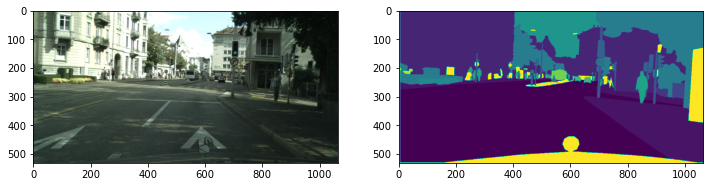

In [14]:
f = plt.figure(figsize=(12,8))
f.add_subplot(1,2, 1)
plt.imshow(x)
f.add_subplot(1,2, 2)
plt.imshow(y)

In [15]:
## create a directory for resized images
if False:
    (PATH/"imgs_532_1064/train").mkdir(parents=True, exist_ok=True)
    (PATH/"imgs_532_1064/val").mkdir(parents=True, exist_ok=True)
    (PATH/"imgs_532_1064/test").mkdir(parents=True, exist_ok=True)
    (PATH/"imgs_532_1064/labels").mkdir(parents=True, exist_ok=True)

In [16]:
def resize_all_imgs(old_folder, new_folder):
    files = [f for f in old_folder.rglob("*.png")]
    for path in files:
        im = read_image(path)
        im2 = resize_image(im)
        new_path = new_folder/path.name
        cv2.imwrite(str(new_path), im2)

# run this once 
if False:
    resize_all_imgs(PATH/"leftImg8bit/train", PATH/"imgs_532_1064/train")
    resize_all_imgs(PATH/"leftImg8bit/val", PATH/"imgs_532_1064/val")
    resize_all_imgs(PATH/"leftImg8bit/test", PATH/"imgs_532_1064/test")
    resize_all_imgs(PATH/"meta", PATH/"imgs_532_1064/labels")

## albumentations for data augmentation 

See other tranformations here: <br>
`https://albumentations.ai/docs/api_reference/augmentations/transforms/` <br>
`https://github.com/albumentations-team/albumentations`

In [17]:
crop = (1024, 512)
transformImg = A.Compose([A.RandomCrop(width=crop[0],height=crop[1]),
                          A.HorizontalFlip(p=.5),
                          A.VerticalFlip(p=.5),
                          A.Rotate(limit = 10, border_mode = cv2.BORDER_REFLECT, value = 0.0, p = .75),
                          A.GridDistortion(border_mode=cv2.BORDER_REFLECT, value=0.0, p=0.75)])          

In [18]:
centercrop = A.CenterCrop(width=crop[0],height=crop[1])

In [19]:
path = PATH/"imgs_532_1064/train/zurich_000051_000019_leftImg8bit.png"
x = read_image(path)
path = PATH/"imgs_532_1064/labels/zurich_000051_000019.png"
y = read_image(path)

In [20]:
transformed = transformImg(image=x, mask=y[:,:,0]) 
img = transformed['image']
mask = transformed['mask']

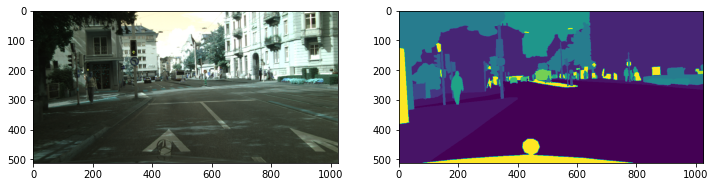

In [21]:
f = plt.figure(figsize=(12,8))
f.add_subplot(1,2, 1)
plt.imshow(img)
f.add_subplot(1,2, 2)
plt.imshow(mask)

In [22]:
transformed = centercrop(image=x, mask=y) 
img = transformed['image']
mask = transformed['mask']

(<matplotlib.image.AxesImage at 0x7f78151a45b0>, (512, 1024, 3))

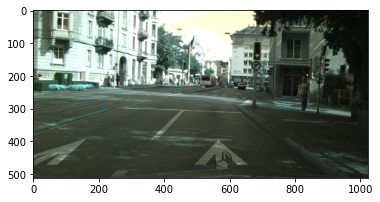

In [23]:
plt.imshow(img), img.shape

## Dataset

In [24]:
class CityScapesDataset(Dataset):
    def __init__(self, data_path, folder, transform=True, crop = (1024, 512)):
        """data_path = PATH/"imgs_532_1064/
           folder is in [val, train, test]
           trasform should be True for train
        """
        self.transform = transform
        self.imgs_files = [f for f in (data_path/folder).glob('*.png')]
        self.label_names = [(f.name).split("_leftImg8bit.png")[0] + ".png" for f in self.imgs_files]
        self.labels_files = [data_path/"labels"/f for f in self.label_names] 
        
        self.train_transforms = A.Compose([
            A.HorizontalFlip(p=.5),
            A.VerticalFlip(p=.5),
            A.Rotate(limit = 10, border_mode = cv2.BORDER_REFLECT, value = 0.0, p = .75),
            A.GridDistortion(border_mode=cv2.BORDER_REFLECT, value=0.0, p=0.75),
            A.RandomCrop(width=crop[0],height=crop[1])]) 
        
        self.val_transforms = A.CenterCrop(width=crop[0],height=crop[1])
        
    def __getitem__(self, index):
        im_path = self.imgs_files[index]
        label_path = self.labels_files[index]
        im = read_image(im_path)
        label = read_image(label_path)
        
        if self.transform:
            transformed = self.train_transforms(image=im, mask=label[:,:,0])
        else:
            transformed = self.val_transforms(image=im, mask=label[:,:,0])
        
        x = transformed['image']/255.
        y = transformed['mask']
        return np.rollaxis(x, 2), y
            
        
    def __len__(self):
        return len(self.imgs_files)

In [25]:
ds_train = CityScapesDataset(PATH/"imgs_532_1064/", "train")
ds_val = CityScapesDataset(PATH/"imgs_532_1064/", "val",  transform=False)

In [26]:
x, y = ds_train[0]
x.shape, y.shape

((3, 512, 1024), (512, 1024))

In [27]:
x, y = ds_val[0]
x.shape, y.shape

((3, 512, 1024), (512, 1024))

In [28]:
len(ds_train), len(ds_val)

(2975, 500)

In [29]:
dl_train = DataLoader(ds_train, batch_size=3, shuffle=True, num_workers=1)
dl_val = DataLoader(ds_val, batch_size=3, shuffle=False, num_workers=1)

## Basic UNet model

In [30]:
# basic unet with batch normalization
f_size = 7
padding = (int((f_size-1)/2),int((f_size-1)/2))
chs = [32, 64, 128, 256, 512] #, 1024]

class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        
        self.relu = nn.ReLU()
        self.conv1 = nn.Conv2d(in_channels, out_channels, f_size, padding=padding)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, f_size, padding=padding)
        self.bn2 = nn.BatchNorm2d(out_channels)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)
        return x

    
class unet(nn.Module):
    
    def __init__(self):
        
        super().__init__()
        # pooling
        self.pool = nn.MaxPool2d(2,2)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        
        # ENCODER
        self.conv00 = ConvBlock(3, 32)
        self.conv10 = ConvBlock(32, 64)
        self.conv20 = ConvBlock(64, 128)
        self.conv30 = ConvBlock(128, 256)
        self.conv40 = ConvBlock(256, 512)
        
        # DECODER
        self.upconv31 = nn.ConvTranspose2d(512, 256, 2, stride=2)
        self.conv31 = ConvBlock(2*256, 256)
        self.upconv22 = nn.ConvTranspose2d(256, 128, 2, stride=2)
        self.conv22 = ConvBlock(2*128, 128)
        self.upconv13 = nn.ConvTranspose2d(128, 64, 2, stride=2)
        self.conv13 = ConvBlock(2*64, 64)
        self.upconv04 = nn.ConvTranspose2d(64, 32, 2, stride=2)
        self.conv04 = ConvBlock(2*32, 32)
        
        # final layers
        self.final04 = nn.Conv2d(32, 20, 1)
         
    def forward(self, x):
        
        # Encoder Path
        x00 = self.conv00(x)
        x10 = self.conv10(self.pool(x00))
        x20 = self.conv20(self.pool(x10))
        x30 = self.conv30(self.pool(x20))
        x40 = self.conv40(self.pool(x30))
        
        # Up-sampling 
        x31 = self.upconv31(x40)
        x31 = self.conv31(torch.cat((x30,x31), dim=1))
        x22 = self.upconv22(x31)
        x22 = self.conv22(torch.cat((x20,x22),dim=1))
        x13 = self.upconv13(x22)
        x13 = self.conv13(torch.cat((x10,x13),dim=1))
        x04 = self.upconv04(x13)
        x04 = self.conv04(torch.cat((x00,x04),dim=1))
        
        # Outputs
        x04 = self.final04(x04)
        
        return x04
    
model = unet().cuda()

In [31]:
x, y = next(iter(dl_train))

In [32]:
y_hat = model(x.float().cuda())
y_hat.shape

torch.Size([3, 20, 512, 1024])

In [33]:
with open(PATH/"meta/class_weights.pkl", "rb") as file: # (needed for python3)
    class_weights = np.array(pickle.load(file))
class_weights = torch.from_numpy(class_weights)
class_weights = class_weights.type(torch.FloatTensor).cuda()

In [34]:
class_weights, class_weights.sum()

(tensor([ 3.3621, 14.0315,  4.9867, 39.2544, 36.5126, 32.8962, 46.2867, 40.6904,
          6.6982, 33.5555, 18.4878, 32.9743, 47.6765, 12.7003, 45.2054, 45.7837,
         45.8253, 48.4061, 42.7559,  7.9122], device='cuda:0'),
 tensor(606.0019, device='cuda:0'))

In [35]:
F.cross_entropy(y_hat, y.long().cuda(), weight=class_weights)

tensor(3.0936, device='cuda:0', grad_fn=<NllLoss2DBackward>)

In [36]:
x.shape, y.shape, y_hat.shape

(torch.Size([3, 3, 512, 1024]),
 torch.Size([3, 512, 1024]),
 torch.Size([3, 20, 512, 1024]))

## training

In [37]:
def valid_metrics(model, dl_valid):
    model.eval()
    batch_losses = []
    for x, y in dl_valid:
        with torch.no_grad(): # reduces memory comsumption
            x = x.float().cuda()
            y = y.long().cuda()
            y_hat = model(x)
            loss = F.cross_entropy(y_hat, y, weight=class_weights)
            batch_losses.append(loss.item())
    return np.mean(batch_losses)

In [42]:
def train_epochs(model, optimizer, dl_train, dl_valid, epochs):
    batch_losses = []
    
    for epoch in range(epochs):
        best_val_loss = valid_metrics(model, dl_valid)
        model.train()
        for x, y in dl_train:
            x = x.float().cuda()
            y = y.long().cuda()
            y_hat = model(x)
            loss = F.cross_entropy(y_hat, y, weight=class_weights)
            batch_losses.append(loss.item())
            
            optimizer.zero_grad() 
            loss.backward() 
            optimizer.step()
        train_loss = np.mean(batch_losses)
        val_loss = valid_metrics(model, dl_valid)
        print ("train loss: %.3f val loss: %.3f" % (train_loss, val_loss))  
        # save the model weights to disk:
        # path = "{0}/models/{1}_r2_{2:.0f}.pth".format(PATH, filename, 100*val_r2_2)
        if val_loss < best_val_loss:
            path = "{0}/models/model.pth".format(PATH)
            print(path)
            torch.save(network.state_dict(), path)
            best_val_loss = val_loss

In [75]:
valid_metrics(model, dl_val)

3.0013732795943757

In [43]:
model = unet().cuda()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=0.0001)
train_epochs(model, optimizer, dl_train, dl_val, epochs=100)

train loss: 1.847 val loss: 1.984
/data2/yinterian/cityscapes/models/model.pth


NameError: name 'network' is not defined